In [6]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [104]:
from tensorflow.keras.datasets import reuters
from tensorflow.keras.layers import Dense, Input, Activation, Flatten, Embedding, SpatialDropout1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
import numpy as np

In [105]:
# Turn off scientific notation
np.set_printoptions(precision=4)
np.set_printoptions(suppress=True)

In [106]:
RANDOM_SEED =4299
np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

In [107]:
(train_data, train_labels), (test_data, test_labels) = reuters.load_data(num_words=10000)

In [108]:
len(train_data)
len(test_data)

8982

2246

In [109]:
word2idx = reuters.get_word_index()

In [110]:
idx2word = dict([(value, key) for (key, value) in word2idx.items()])

In [111]:
idx2word[1]

'the'

In [112]:
# Note that the indices are offset by 3 because 0, 1, and 2 are reserved indices for “padding,” “start of sequence,” and “unknown.”
# I AM NOT SURE ABOUT THIS ?????? (this is from Francois Chalot Keras book)
decoded_review = ' '.join([idx2word.get(i-3, '?') for i in train_data[0]])
decoded_review

'? ? ? said as a result of its december acquisition of space co it expects earnings per share in 1987 of 1 15 to 1 30 dlrs per share up from 70 cts in 1986 the company said pretax net should rise to nine to 10 mln dlrs from six mln dlrs in 1986 and rental operation revenues to 19 to 22 mln dlrs from 12 5 mln dlrs it said cash flow per share this year should be 2 50 to three dlrs reuter 3'

In [188]:
MAX_TEXT_LENGTH = 100
PAD_TYPE = TRUNC_TYPE = 'post'
NUM_CLASSES = len(np.unique(train_labels))
print("NUM CLASSES : ", NUM_CLASSES)

NUM CLASSES :  46


In [114]:
X_train = pad_sequences(train_data, maxlen=MAX_TEXT_LENGTH, padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)
X_test = pad_sequences(test_data, maxlen=MAX_TEXT_LENGTH, padding=PAD_TYPE, truncating=TRUNC_TYPE, value=0)

In [115]:
X_train = np.asarray(X_train).astype('float32')
X_test = np.asarray(X_test).astype('float32')

In [116]:
X_train[0]

array([   1.,    2.,    2.,    8.,   43.,   10.,  447.,    5.,   25.,
        207.,  270.,    5., 3095.,  111.,   16.,  369.,  186.,   90.,
         67.,    7.,   89.,    5.,   19.,  102.,    6.,   19.,  124.,
         15.,   90.,   67.,   84.,   22.,  482.,   26.,    7.,   48.,
          4.,   49.,    8.,  864.,   39.,  209.,  154.,    6.,  151.,
          6.,   83.,   11.,   15.,   22.,  155.,   11.,   15.,    7.,
         48.,    9., 4579., 1005.,  504.,    6.,  258.,    6.,  272.,
         11.,   15.,   22.,  134.,   44.,   11.,   15.,   16.,    8.,
        197., 1245.,   90.,   67.,   52.,   29.,  209.,   30.,   32.,
        132.,    6.,  109.,   15.,   17.,   12.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.], dtype=float32)

In [117]:
y_train = np.asarray(train_labels).astype('float32')
y_test = np.asarray(test_labels).astype('float32')

In [118]:
y_train[0]

3.0

### Preparing Labels

In [119]:
le = LabelEncoder()
y_train = y_train.tolist()
le.fit(y_train)

LabelEncoder()

In [120]:
def encode(le, labels):
    enc = le.transform(labels)
    return to_categorical(enc)

In [121]:
def decode(le, one_hot):
    dec = np.argmax(one_hot, axis=1)
    return le.inverse_transform(dec)

In [122]:
y_train = encode(le, y_train)
y_test = encode(le, y_test)

In [123]:
# to_categorical da ayni seyi yapar ama daha sonra decode etmek istedigimizde yukaridaki yondetme daha makul
# y_train = to_categorical(y_train)

In [124]:
y_train[0]

array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [125]:
y_train.shape

(8982, 46)

### Model

In [126]:
from sklearn.model_selection import train_test_split

In [127]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, random_state=4299, test_size=0.2)

In [128]:
X_train.shape

(7185, 100)

In [189]:
n_unique_words = 10000
n_dim = 128
drop_embed = 0.2

In [208]:
model = Sequential()
model.add(Embedding(n_unique_words, n_dim, input_length=MAX_TEXT_LENGTH))
#model.add(SpatialDropout1D(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(64, activation='relu'))
#model.add(Dense(46, activation='tanh'))
model.add(Dropout(0.5))
model.add(Dense(46, activation='softmax'))

In [209]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_16 (Embedding)     (None, 100, 128)          1280000   
_________________________________________________________________
flatten_16 (Flatten)         (None, 12800)             0         
_________________________________________________________________
dense_50 (Dense)             (None, 128)               1638528   
_________________________________________________________________
dropout_31 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_51 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_32 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_52 (Dense)             (None, 46)              

In [210]:
model.compile(loss='categorical_crossentropy', 
             optimizer='adam',
             metrics=['accuracy'])

In [211]:
history = model.fit(X_train, y_train,
                   epochs=20,
                   batch_size=512,
                   validation_data=(X_valid, y_valid))

Train on 7185 samples, validate on 1797 samples
Epoch 1/20
7185/7185 [==============================] - 1s 135us/sample - loss: 3.1085 - accuracy: 0.3159 - val_loss: 2.4174 - val_accuracy: 0.3561
Epoch 2/20
7185/7185 [==============================] - 1s 87us/sample - loss: 2.3162 - accuracy: 0.4166 - val_loss: 2.0309 - val_accuracy: 0.4919
Epoch 3/20
7185/7185 [==============================] - 1s 81us/sample - loss: 1.9115 - accuracy: 0.5162 - val_loss: 1.8269 - val_accuracy: 0.5559
Epoch 4/20
7185/7185 [==============================] - 1s 82us/sample - loss: 1.6585 - accuracy: 0.5943 - val_loss: 1.6953 - val_accuracy: 0.6043
Epoch 5/20
7185/7185 [==============================] - 1s 81us/sample - loss: 1.4574 - accuracy: 0.6374 - val_loss: 1.5922 - val_accuracy: 0.6311
Epoch 6/20
7185/7185 [==============================] - 1s 82us/sample - loss: 1.2671 - accuracy: 0.6772 - val_loss: 1.5209 - val_accuracy: 0.6566
Epoch 7/20
7185/7185 [==============================] - 1s 83us/sampl

### Loss Plot

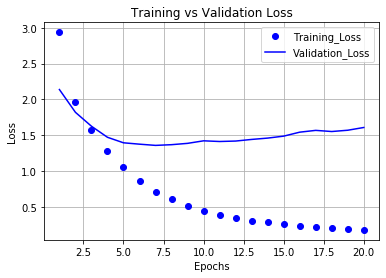

In [151]:
import matplotlib.pyplot as plt
hist_dict = history.history
loss_values = hist_dict['loss']
val_loss_values = hist_dict['val_loss']

epochs = range(1, len(loss_values)+1)

plt.plot(epochs, loss_values, 'bo', label='Training_Loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation_Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show();

### Accuracy Plot

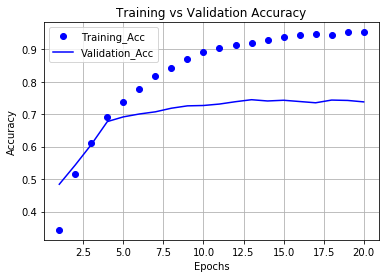

In [152]:
plt.clf()
acc_values = hist_dict['accuracy']
val_acc_values = hist_dict['val_accuracy']

epochs = range(1, len(acc_values)+1)

plt.plot(epochs, acc_values, 'bo', label='Training_Acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation_Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show();

### Test Results

In [153]:
model.evaluate(X_test, y_test)

2246/2246 [==============================] - 0s 64us/sample - loss: 1.6158 - accuracy: 0.7453


[1.6158410324545067, 0.745325]

In [198]:
y_pred = model.predict(X_test)

In [199]:
np.argmax(y_pred[0])

30